Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.1"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

Cell (0, 0): 0
Cell (0, 1): 0
Cell (0, 2): 1
Cell (0, 3): 7
Cell (0, 4): 0 1
Cell (0, 5): 2
Cell (0, 6): 9
Cell (0, 7): 0 1
Cell (0, 8): 0 1
Cell (1, 0): 8
Cell (1, 1): 7
Cell (1, 2): 0 1
Cell (1, 3): 0 1
Cell (1, 4): 0 0
Cell (1, 5): 0 1
Cell (1, 6): 0 0
Cell (1, 7): 4
Cell (1, 8): 2
Cell (2, 0): 0 1
Cell (2, 1): 0 0
Cell (2, 2): 0 1
Cell (2, 3): 0 1
Cell (2, 4): 4
Cell (2, 5): 0 1
Cell (2, 6): 0 0
Cell (2, 7): 0 0
Cell (2, 8): 0 0
Cell (3, 0): 6.
Cell (3, 1): 0
Cell (3, 2): 0
Cell (3, 3): 0
Cell (3, 4): 5
Cell (3, 5): 0
Cell (3, 6): 7
Cell (3, 7): 0 0
Cell (3, 8): g
Cell (4, 0): 7
Cell (4, 1): 0
Cell (4, 2): 0 1
Cell (4, 3): 0 0
Cell (4, 4): 1.
Cell (4, 5): 0 1
Cell (4, 6): 0 0
Cell (4, 7): 0 0
Cell (4, 8): 3
Cell (5, 0): 4
Cell (5, 1): 0 1
Cell (5, 2): 2
Cell (5, 3): 0 0
Cell (5, 4): 8
Cell (5, 5): 0 1
Cell (5, 6): 0 0
Cell (5, 7): 0 0
Cell (5, 8): 11
Cell (6, 0): 0
Cell (6, 1): 0
Cell (6, 2): 0
Cell (6, 3): 0
Cell (6, 4): 6.
Cell (6, 5): 0
Cell (6, 6): 0 0
Cell (6, 7): 0
Cell (6, 8

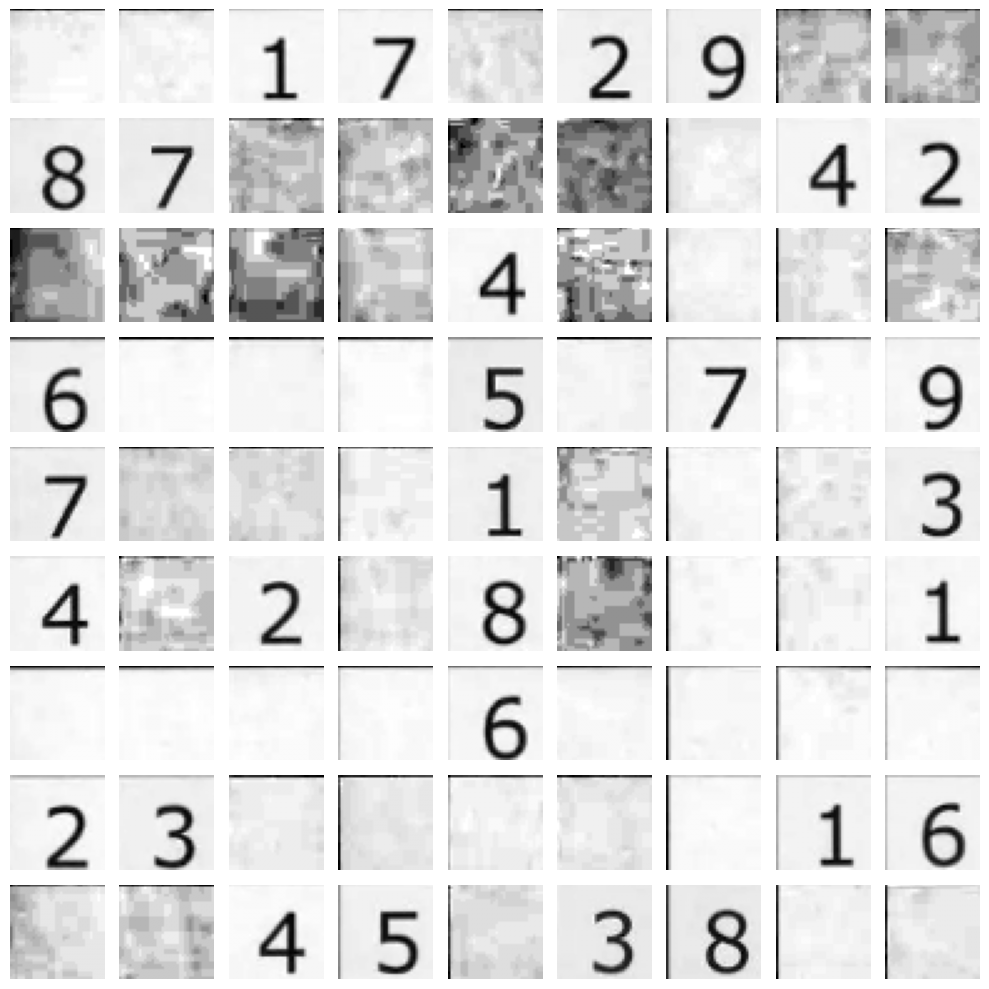

In [30]:
from transformers import pipeline, AutoProcessor, VisionEncoderDecoderModel
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re
import os

# Save the model and processor to a local folder (e.g., './local_model')
save_path = "./local_model"

# Use the model from the local folder with PyTorch
pipe = pipeline("image-to-text", model="./local_model", framework="pt")
# Load the image
img = cv2.imread('sudoku1.png', cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur
proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)

# Apply adaptive thresholding
proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Invert the image to make grid lines white
proc = cv2.bitwise_not(proc, proc)

# Dilate the image to enhance grid lines
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
proc = cv2.dilate(proc, kernel)

# Find contours in the image
contours, _ = cv2.findContours(proc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area and select the largest one
contours = sorted(contours, key=cv2.contourArea, reverse=True)
polygon = contours[0]

# Function to calculate the distance between two points
def distance_between(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Find the four extreme points of the contour
bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=lambda x: x[1])
top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=lambda x: x[1])
bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=lambda x: x[1])
top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=lambda x: x[1])

# Extract the four corners
crop_rect = [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

# Calculate the side length of the square
side = max([
    distance_between(crop_rect[0], crop_rect[1]),
    distance_between(crop_rect[1], crop_rect[2]),
    distance_between(crop_rect[2], crop_rect[3]),
    distance_between(crop_rect[3], crop_rect[0])
])

# Define the destination points for the perspective transform
dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

# Perform the perspective transform
m = cv2.getPerspectiveTransform(np.array(crop_rect, dtype='float32'), dst)
warped = cv2.warpPerspective(img, m, (int(side), int(side)))

# Infer the 81 cell grid
squares = []
side = warped.shape[0] // 9
for j in range(9):
    row = []
    for i in range(9):
        p1 = (i * side, j * side)  # Top-left corner of the cell
        p2 = ((i + 1) * side, (j + 1) * side)  # Bottom-right corner of the cell
        row.append((p1, p2))
    squares.append(row)

# Create subplot grid
fig, axs = plt.subplots(9, 9, figsize=(10, 10))

# Extract and display cropped cells
for row_idx, row in enumerate(squares):
    for col_idx, square in enumerate(row):
        p1, p2 = square
        # Extract the cell
        cell = warped[int(p1[1]):int(p2[1]), int(p1[0]):int(p2[0])]
        
        # Crop borders (adjust the margin as needed)
        margin = int(cell.shape[0] * 0.12)  # 15% margin
        cell = cell[margin:-margin, margin:-margin]
        
        # Display the cropped cell
        axs[row_idx, col_idx].imshow(cell, cmap='gray')
        axs[row_idx, col_idx].axis('off')
        
        # Save the cell image temporarily to pass it to the pipeline
        cell_path = f"cell_{row_idx}_{col_idx}.png"
        cv2.imwrite(cell_path, cell)
        
        # Use the pipeline to recognize text from the cell image
        result = pipe(cell_path)
        recognized_text = result[0]['generated_text']
        
        # Check if the recognized text is a single-digit number
        if re.match(r'^\d$', recognized_text):
            print(f"Cell ({row_idx}, {col_idx}): {recognized_text}")
        else:
            print(f"Cell ({row_idx}, {col_idx}): {recognized_text}")

plt.tight_layout()
plt.show()

In [32]:
from transformers import pipeline
from PIL import Image

# Load the model from your local folder (ensure it has been saved there already)
pipe = pipeline("image-to-text", model="./local_model", framework="pt")

# Open the image (make sure the image path is correct)
image = Image.open("sudoku1.png")

# Get the predicted text from the image
result = pipe(image)

# Print the result
print("Predicted text:", result[0]['generated_text'])


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.1"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

Predicted text: 25 6.


In [13]:
from transformers import pipeline
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re

# Path to the local directory where the model is saved
save_directory = "./local_model"

# Load the model, feature extractor, and tokenizer from the local directory
model = VisionEncoderDecoderModel.from_pretrained(save_directory)
feature_extractor = ViTFeatureExtractor.from_pretrained(save_directory)
tokenizer = AutoTokenizer.from_pretrained(save_directory)

# Create the pipeline using the locally loaded model, feature extractor, and tokenizer
pipe = pipeline(
    "image-to-text",
    model=model,
    feature_extractor=feature_extractor,
    tokenizer=tokenizer,
    framework="pt"
)

# Load the image
img = cv2.imread('sudoku.jpg', cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur
proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)

# Apply adaptive thresholding
proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Invert the image to make grid lines white
proc = cv2.bitwise_not(proc, proc)

# Dilate the image to enhance grid lines
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
proc = cv2.dilate(proc, kernel)

# Find contours in the image
contours, _ = cv2.findContours(proc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area and select the largest one
contours = sorted(contours, key=cv2.contourArea, reverse=True)
polygon = contours[0]

# Function to calculate the distance between two points
def distance_between(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Find the four extreme points of the contour
bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=lambda x: x[1])
top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=lambda x: x[1])
bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=lambda x: x[1])
top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=lambda x: x[1])

# Extract the four corners
crop_rect = [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

# Calculate the side length of the square
side = max([
    distance_between(crop_rect[0], crop_rect[1]),
    distance_between(crop_rect[1], crop_rect[2]),
    distance_between(crop_rect[2], crop_rect[3]),
    distance_between(crop_rect[3], crop_rect[0])
])

# Define the destination points for the perspective transform
dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

# Perform the perspective transform
m = cv2.getPerspectiveTransform(np.array(crop_rect, dtype='float32'), dst)
warped = cv2.warpPerspective(img, m, (int(side), int(side)))

# Infer the 81 cell grid
squares = []
side = warped.shape[0] // 9
for j in range(9):
    row = []
    for i in range(9):
        p1 = (i * side, j * side)  # Top-left corner of the cell
        p2 = ((i + 1) * side, (j + 1) * side)  # Bottom-right corner of the cell
        row.append((p1, p2))
    squares.append(row)

# Create a 9x9 grid to store the Sudoku puzzle
sudoku_grid = [[0 for _ in range(9)] for _ in range(9)]

# Extract and display cropped cells
for row_idx, row in enumerate(squares):
    for col_idx, square in enumerate(row):
        p1, p2 = square
        # Extract the cell
        cell = warped[int(p1[1]):int(p2[1]), int(p1[0]):int(p2[0])]
        
        # Crop borders (adjust the margin as needed)
        margin = int(cell.shape[0] * 0.15)  # 15% margin
        cell = cell[margin:-margin, margin:-margin]
        
        # Save the cell image temporarily to pass it to the pipeline
        cell_path = f"cell_{row_idx}_{col_idx}.png"
        cv2.imwrite(cell_path, cell)
        
        # Use the pipeline to recognize text from the cell image
        result = pipe(cell_path)
        recognized_text = result[0]['generated_text']
        
        # Check if the recognized text is a single-digit number
        if re.match(r'^\d$', recognized_text):
            sudoku_grid[row_idx][col_idx] = int(recognized_text)
        else:
            sudoku_grid[row_idx][col_idx] = 0  # Fill with 0 for invalid entries

# Print the Sudoku grid
print("Sudoku Grid:")
for row in sudoku_grid:
    print(row)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.1"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

Sudoku Grid:
[0, 0, 1, 8, 9, 2, 6, 0, 0]
[0, 9, 0, 0, 0, 0, 0, 2, 2]
[0, 5, 0, 0, 0, 0, 0, 0, 0]
[0, 8, 4, 0, 0, 0, 0, 0, 0]
[0, 0, 3, 5, 4, 7, 9, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 5, 0]
[0, 0, 0, 0, 0, 0, 0, 3, 0]
[0, 7, 0, 0, 0, 0, 0, 8, 0]
[0, 2, 8, 1, 5, 3, 4, 0, 0]


In [43]:
from transformers import pipeline
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re

# Path to the local directory where the model is saved
save_directory = "./local_model"

# Load the model, feature extractor, and tokenizer from the local directory
model = VisionEncoderDecoderModel.from_pretrained(save_directory)
feature_extractor = ViTFeatureExtractor.from_pretrained(save_directory)
tokenizer = AutoTokenizer.from_pretrained(save_directory)

# Create the pipeline using the locally loaded model, feature extractor, and tokenizer
pipe = pipeline(
    "image-to-text",
    model=model,
    feature_extractor=feature_extractor,
    tokenizer=tokenizer,
    framework="pt"
)

# Load the image
img = cv2.imread('sudoku3.png', cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur
proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)

# Apply adaptive thresholding
proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Invert the image to make grid lines white
proc = cv2.bitwise_not(proc, proc)

# Dilate the image to enhance grid lines
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
proc = cv2.dilate(proc, kernel)

# Find contours in the image
contours, _ = cv2.findContours(proc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area and select the largest one
contours = sorted(contours, key=cv2.contourArea, reverse=True)
polygon = contours[0]

# Function to calculate the distance between two points
def distance_between(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Find the four extreme points of the contour
bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=lambda x: x[1])
top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=lambda x: x[1])
bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=lambda x: x[1])
top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=lambda x: x[1])

# Extract the four corners
crop_rect = [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

# Calculate the side length of the square
side = max([
    distance_between(crop_rect[0], crop_rect[1]),
    distance_between(crop_rect[1], crop_rect[2]),
    distance_between(crop_rect[2], crop_rect[3]),
    distance_between(crop_rect[3], crop_rect[0])
])

# Define the destination points for the perspective transform
dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

# Perform the perspective transform
m = cv2.getPerspectiveTransform(np.array(crop_rect, dtype='float32'), dst)
warped = cv2.warpPerspective(img, m, (int(side), int(side)))

# Infer the 81 cell grid
squares = []
side = warped.shape[0] // 9
for j in range(9):
    row = []
    for i in range(9):
        p1 = (i * side, j * side)  # Top-left corner of the cell
        p2 = ((i + 1) * side, (j + 1) * side)  # Bottom-right corner of the cell
        row.append((p1, p2))
    squares.append(row)

# Create a 9x9 grid to store the Sudoku puzzle
sudoku_grid = [[0 for _ in range(9)] for _ in range(9)]

# Threshold for detecting blank cells (adjust as needed)
blank_threshold = 10  # Standard deviation threshold

# Extract and display cropped cells
for row_idx, row in enumerate(squares):
    for col_idx, square in enumerate(row):
        p1, p2 = square
        # Extract the cell
        cell = warped[int(p1[1]):int(p2[1]), int(p1[0]):int(p2[0])]
        
        # Crop borders (adjust the margin as needed)
        margin = int(cell.shape[0] * 0.10)  # 15% margin
        cell = cell[margin:-margin, margin:-margin]
        
        # Check if the cell is blank
        if np.std(cell) < blank_threshold:
            sudoku_grid[row_idx][col_idx] = 0  # Mark as blank
            continue  # Skip TrOCR prediction for blank cells
        
        # Save the cell image temporarily to pass it to the pipeline
        cell_path = f"cell_{row_idx}_{col_idx}.png"
        cv2.imwrite(cell_path, cell)
        
        # Use the pipeline to recognize text from the cell image
        result = pipe(cell_path)
        recognized_text = result[0]['generated_text']
        
        misclassification_map = {
                # Common misclassifications due to shape similarity
                'g': '9', 'q': '9', 'b': '6', 'o': '0', 'O': '0', 'D': '0',
                'l': '1', 'I': '1', 'i': '1', '|': '1', '!': '1', 'L': '1',
                's': '5', 'S': '5', 'z': '2', 'Z': '2', 'T': '7',

                # Grid-line artifacts and misclassifications
                '1 1': '1', '0 0': '0', '1|': '1', '|1': '1', 
                '1l': '1', 'l1': '1', 'I1': '1', '1I': '1', '1!': '1', '!1': '1',
                'l|': '1', '|l': '1', 'I|': '1', '|I': '1', 'L|': '1', '|L': '1',

                # Misclassified multi-digit numbers due to grid artifacts
                '11': '1', '12': '2', '13': '3', '14': '4', '15': '5', '16': '6',
                '17': '7', '18': '8', '19': '9', '21': '2', '22': '2', '23': '3',
                '31': '3', '41': '4', '51': '5', '61': '6', '71': '7', '81': '8',
                '91': '9', '2 2': '2', '3 3': '3', '4 4': '4', '5 5': '5',
                '6 6': '6', '7 7': '7', '8 8': '8', '9 9': '9'
            }
            # If the recognized text is a single digit, store it; otherwise store 0
        corrected_text = misclassification_map.get(recognized_text, recognized_text)

        # Use a capturing group to get the digit part
        match = re.match(r'^(\d)\.?$', corrected_text)
        if match:
            # Extract the digit from the match and convert to int
            sudoku_grid[row_idx][col_idx] = int(match.group(1))
        else:
            sudoku_grid[row_idx][col_idx] = recognized_text

# Print the Sudoku grid
print("Sudoku Grid:")
for row in sudoku_grid:
    print(row)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.1"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

Sudoku Grid:
['0 0', 9, 2, 1, '0 0', 5, 0, 0, 4]
[0, 0, 8, 0, 7, 3, 5, 0, 9]
[0, 5, 3, 0, 4, 0, 0, 2, 0]
[1, 4, 0, 0, 0, 0, 7, 3, 6]
['0 0', 0, 0, 7, 6, '1 1', 4, 0, 5]
['0 0', 7, 0, 5, 0, 0, 0, 0, 0]
[9, 0, 0, 0, 0, 7, 2, 0, 0]
['0 0', 0, 4, 0, 0, 6, 0, 9, 0]
['0 0', 0, 0, 0, 0, 0, 0, 0, 0]
